# Neighborhood Analysis

To find structures within our tissues, we can use the concept of cellular neighborhoods. The idea is that we start by defining neighborhoods for each cell, which consist of the relative abundances of the surrounding cell types. Afterwards, we can use clustering across multiple samples to define the neighborhoods. Finally, we can add these neighborhood labels back into the `spatialproteomics` object and use them to select specific regions of the tissue.

In [16]:
%reload_ext autoreload
%autoreload 2

import spatialproteomics as sp
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from sklearn.cluster import KMeans

As a first step, we open three datasets and store them inside of a dictionary.

In [17]:
sp_obj_1 = xr.open_dataset('/g/huber/projects/CODEX/TRIANGLE/TRIANGLE_processed/1_F6.zarr', engine='zarr')
sp_obj_2 = xr.open_dataset('/g/huber/projects/CODEX/TRIANGLE/TRIANGLE_processed/1_F7.zarr', engine='zarr')
sp_obj_3 = xr.open_dataset('/g/huber/projects/CODEX/TRIANGLE/TRIANGLE_processed/1_C6.zarr', engine='zarr')

In [18]:
sp_dict = {'1': sp_obj_1, '2': sp_obj_2, '3': sp_obj_3}

We can use the method `pp.compute_neighborhoods_radius()` to compute the neighborhood profiles, which will be written into a new layer called `_neighborhoods`. This method takes a radius around each cell and returns the relative cell type frequencies within that radius. Here, we use `pp.get_layer_as_df()` to investigate what this looks like.

In [19]:
sp_obj_1.pp.compute_neighborhoods_radius().pp.get_layer_as_df('_neighborhoods').head()

,B,Dendritic,Macro,Myeloid,Stroma CD31,Stroma CD34,Stroma CD90,Stroma PDPN,T
1,0.666667,0.000000,0.041667,0.020833,0.0,0.0,0.000000,0.020833,0.250000
2,0.769231,0.019231,0.000000,0.038462,0.0,0.0,0.019231,0.000000,0.153846
3,0.763636,0.018182,0.000000,0.036364,0.0,0.0,0.018182,0.000000,0.163636
4,0.745098,0.019608,0.000000,0.039216,0.0,0.0,0.019608,0.000000,0.176471
5,0.692308,0.019231,0.038462,0.038462,0.0,0.0,0.019231,0.019231,0.173077


Each cell now has a neighborhood associated with it, which is defined as the relative abundance of the surrounding cell types (including the cell itself). We can do this across all three datasets, and then aggregate the results into a single data frame.

In [20]:
df = []
for id, sp_obj in sp_dict.items():
    df.append(sp_obj.pp.compute_neighborhoods_radius().pp.get_layer_as_df('_neighborhoods'))
# replacing nans with 0s (this means that the ct was never called in that specific sample)
df = pd.concat(df).fillna(0)
df

,B,Dendritic,Macro,Myeloid,Stroma CD31,Stroma CD34,Stroma CD90,Stroma PDPN,T
1,0.666667,0.000000,0.041667,0.020833,0.0,0.0,0.000000,0.020833,0.250000
2,0.769231,0.019231,0.000000,0.038462,0.0,0.0,0.019231,0.000000,0.153846
3,0.763636,0.018182,0.000000,0.036364,0.0,0.0,0.018182,0.000000,0.163636
4,0.745098,0.019608,0.000000,0.039216,0.0,0.0,0.019608,0.000000,0.176471
5,0.692308,0.019231,0.038462,0.038462,0.0,0.0,0.019231,0.019231,0.173077
...,...,...,...,...,...,...,...,...,...
6924,0.892308,0.015385,0.000000,0.015385,0.0,0.0,0.000000,0.000000,0.076923
6925,0.953846,0.000000,0.000000,0.030769,0.0,0.0,0.000000,0.000000,0.015385
6926,0.984375,0.000000,0.000000,0.015625,0.0,0.0,0.000000,0.000000,0.000000
6927,0.984375,0.000000,0.000000,0.015625,0.0,0.0,0.000000,0.000000,0.000000


We can now perform k-means clustering on this large data frame. Note that you could also use alternative clustering approaches, however some of them (e. g. hierarchical clustering) might be difficult to apply to large data sets, since they require the computation of a full pairwise distance matrix.

In [21]:
# Running K-Means clustering (here with k=4, you could adjust that to your liking)
clusterer = KMeans(n_clusters=4, random_state=0)
clusterer.fit(df)
kmeans_df = pd.DataFrame({f'labels': clusterer.labels_})
kmeans_df

,labels
0,0
1,1
2,1
3,0
4,0
...,...
14190,1
14191,1
14192,1
14193,1


Now we have a large data frame containing the neighborhood labels. We can add them back into the `spatialproteomics` objects with `pp.add_feature()`.

In [22]:
# adding the neighborhoods back into the graph
for sample_id, sp_obj in sp_dict.items():
    num_cells = sp_obj.sizes['cells']
    # getting the labels for the number of cells
    tmp_df = kmeans_df[:num_cells]
    # removing those cells from the kmeans_df
    kmeans_df = kmeans_df[num_cells:]
    sp_dict[sample_id] = sp_obj.pp.add_feature('k-means_label', tmp_df['labels'].values)

Finally, we can plot the results. Let's look at both the cellular neighborhoods as well as the original cell type labels.

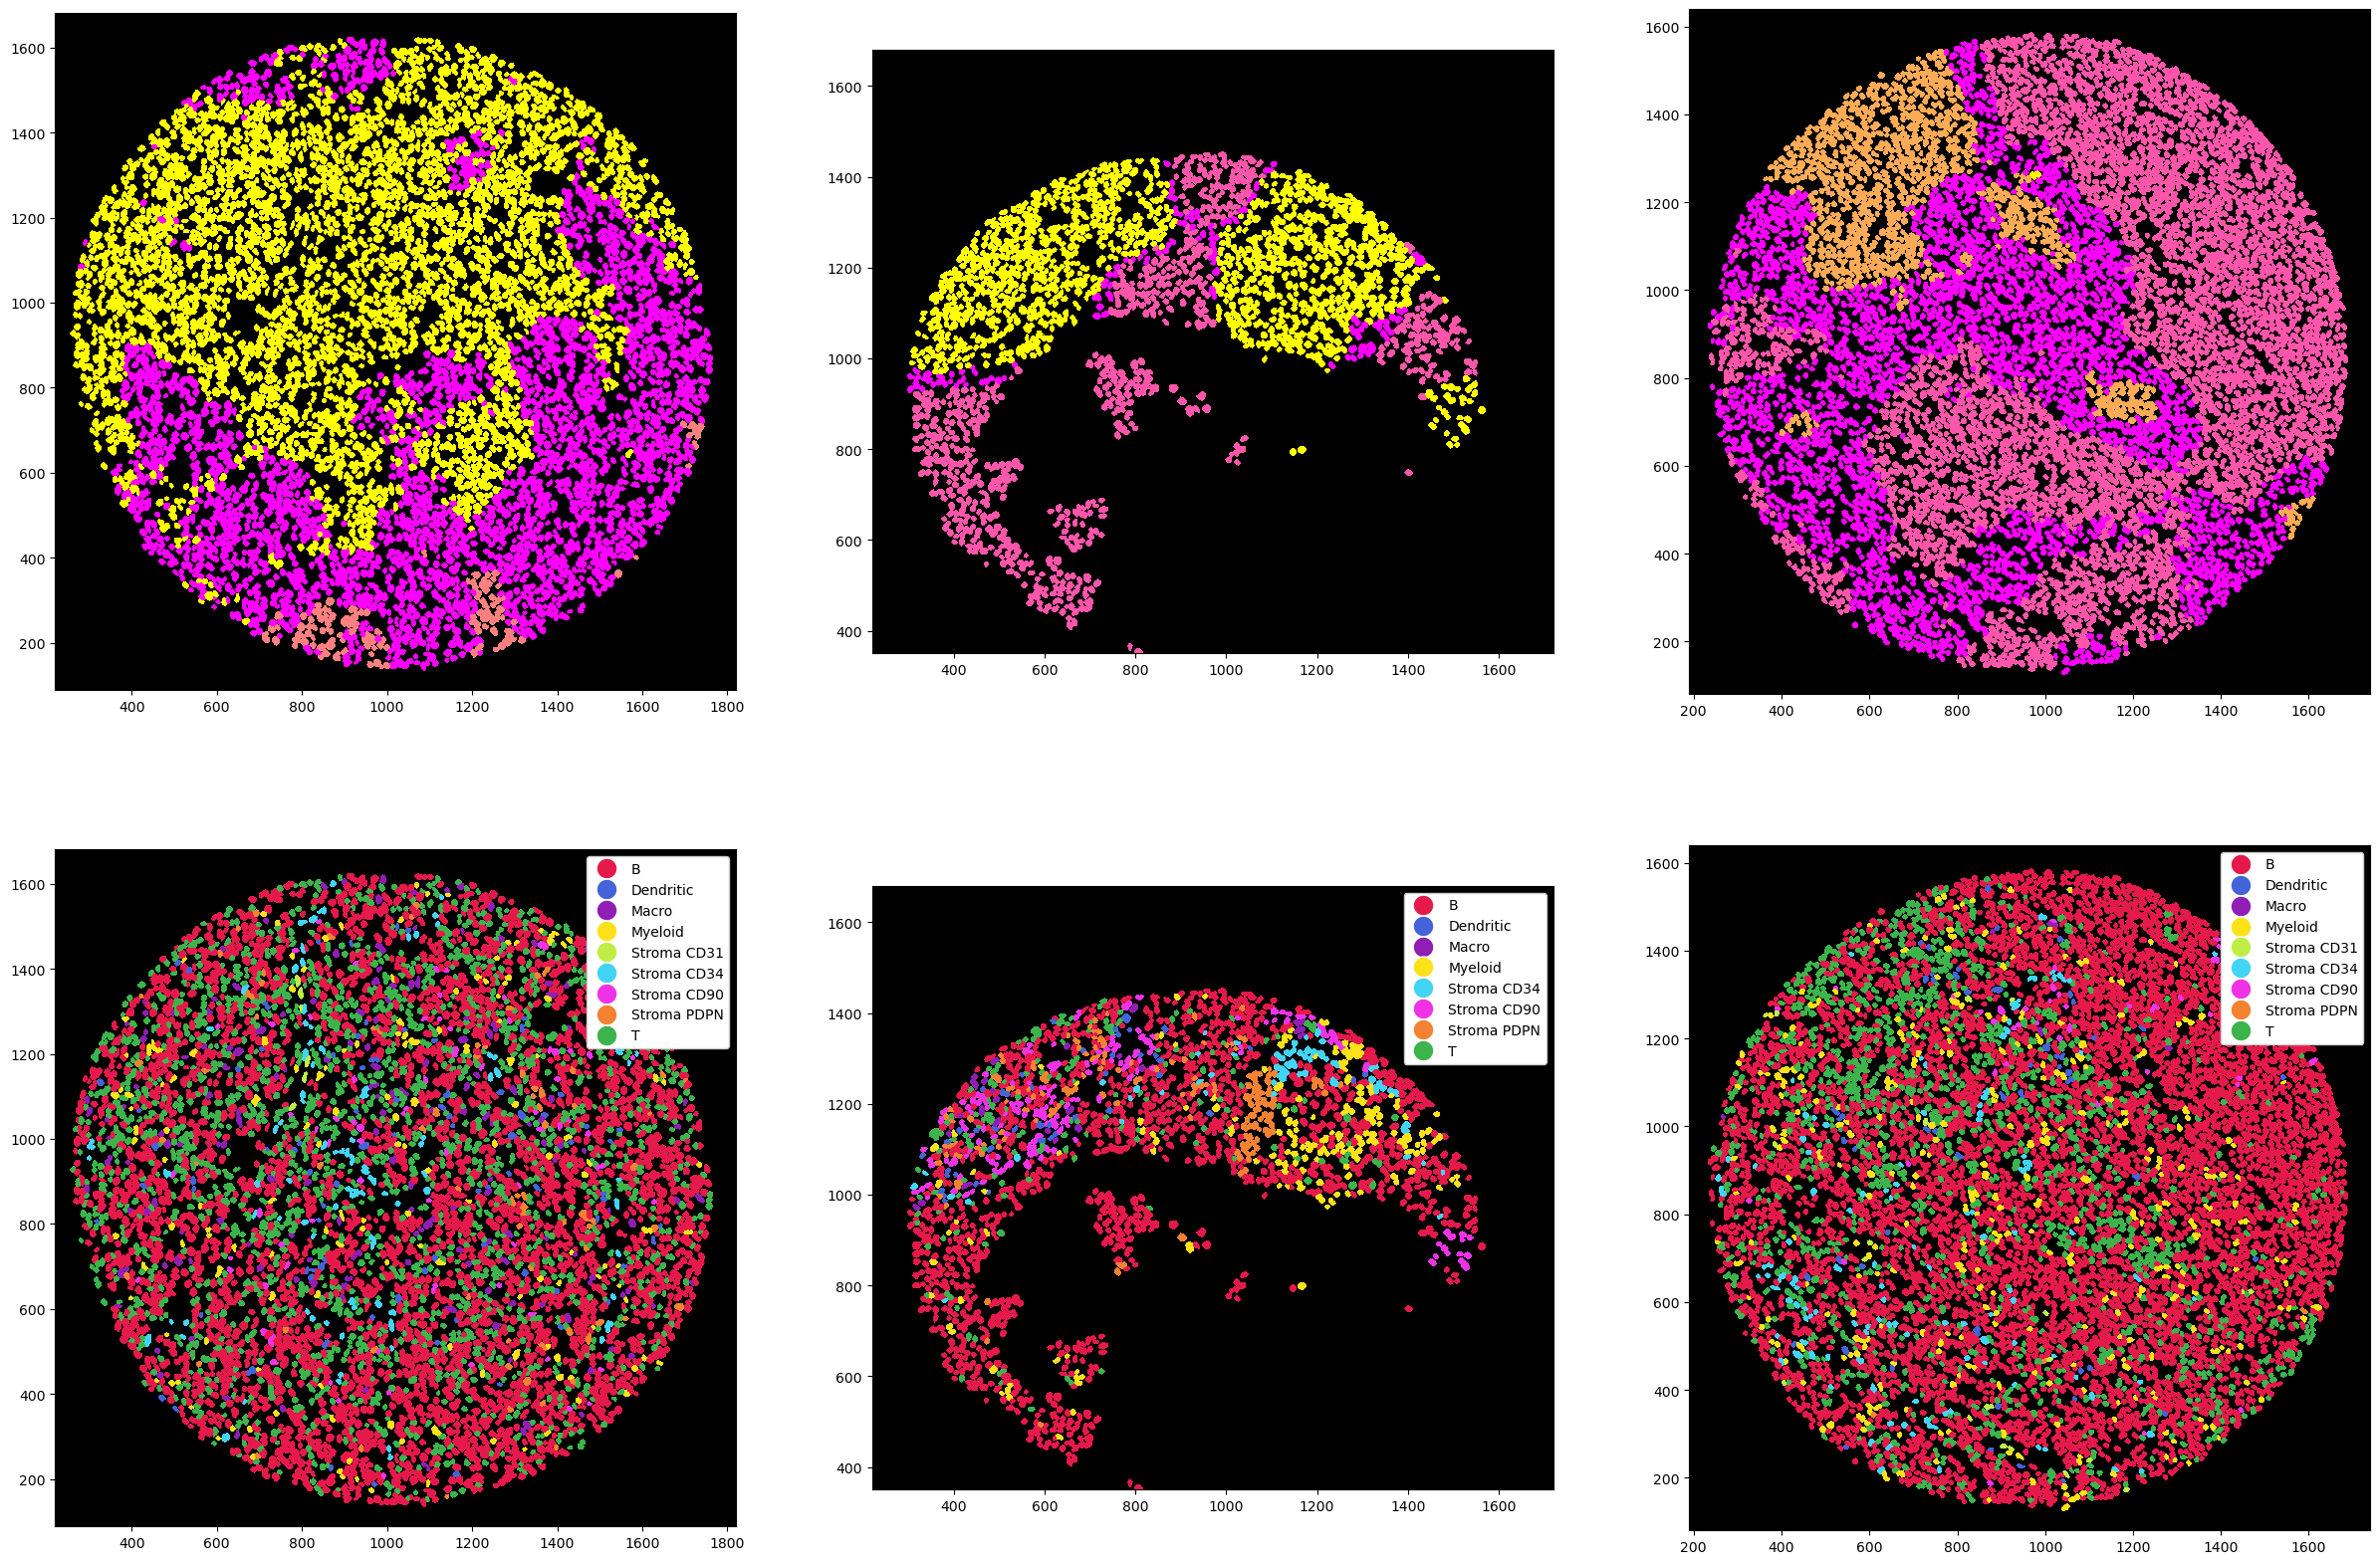

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax = ax.flatten()

_ = sp_dict['1'].pl.autocrop().pl.render_obs('k-means_label', cmap='spring').pl.imshow(ax=ax[0])
_ = sp_dict['2'].pl.autocrop().pl.render_obs('k-means_label', cmap='spring').pl.imshow(ax=ax[1])
_ = sp_dict['3'].pl.autocrop().pl.render_obs('k-means_label', cmap='spring').pl.imshow(ax=ax[2])

_ = sp_dict['1'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[3])
_ = sp_dict['2'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[4])
_ = sp_dict['3'].pl.autocrop().pl.show(render_image=False, render_labels=True, ax=ax[5])